In [1]:
from monai.utils import first, set_determinism
from monai import transforms
from monai.data import Dataset, DataLoader
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import u_net
from monai import inferers
import nibabel as nib
import utils

In [2]:
in_dir = Path.cwd()
target_dir = in_dir.parent / 'models'
target_dir.is_dir()

True

In [3]:
train_loss = np.load(target_dir / 'train_loss.npy' )
train_metric = np.load(target_dir / 'train_metric.npy')
test_loss = np.load(target_dir / 'test_loss.npy')
test_metric = np.load(target_dir / 'test_metric.npy')

In [4]:
# Debug
(target_dir / 'train_loss.npy').is_file(),(target_dir / 'train_metric.npy').is_file(), (target_dir / 'test_loss.npy').is_file(), (target_dir / 'test_metric.npy').is_file()


(True, True, True, True)

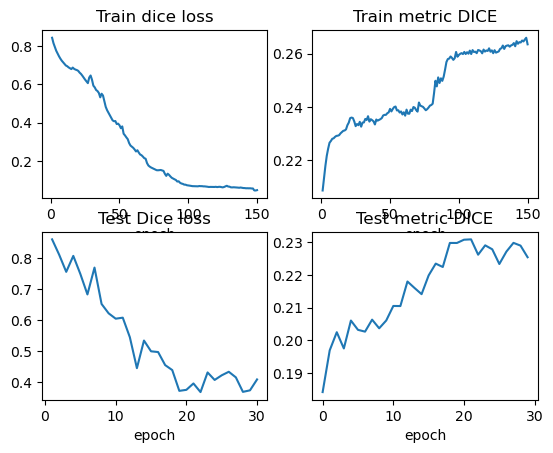

In [20]:
plt.figure(f'Results of {datetime.now().strftime("%d %B")}')
plt.subplot(2, 2, 1)
plt.title('Train dice loss')
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title('Train metric DICE')
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title('Test Dice loss')
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title('Test metric DICE')
x = [i for i in range(len(test_metric))]
y = test_metric
plt.xlabel('epoch')
plt.plot(x, y)

plt.show()

In [5]:
path_train_volumes = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'train_volumes').glob('*'))
path_train_segmentations = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'train_segmentations').glob('*'))

path_test_volumes = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'test_volumes').glob('*'))
path_test_segmentations = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'test_segmentations').glob('*'))

train_files = [{'vol': image_name, 'seg': label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentations)]
test_files = [{'vol': image_name, 'seg': label_name} for image_name, label_name in zip (path_test_volumes, path_test_segmentations)]

In [6]:
test_transform: transforms = transforms.Compose([
        transforms.LoadImaged(keys = ['vol', 'seg']),
        transforms.EnsureChannelFirstd(keys = ['vol', 'seg']),
        transforms.CropForegroundd(keys = ['vol', 'seg'], source_key = 'vol'),
        transforms.ScaleIntensityRanged(keys = ['vol'], a_min = - 200, a_max = 200, b_min = 0., b_max = 1., clip = True),
        transforms.Spacingd(keys = ['vol', 'seg'], pixdim = (1.5, 1.5, 1.0), mode = ('bilinear', 'nearest')),
        transforms.Orientationd(keys = ['vol', 'seg'], axcodes = 'RAS'),
        transforms.Resized(keys = ['vol', 'seg'], spatial_size = [128, 128, 64], mode = ('bilinear', 'nearest')),    
        transforms.ToTensor()
    ])

c:\Users\graumnitz\AppData\Local\anaconda3\envs\heart\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [7]:
num_workers = os.cpu_count()

test_ds = Dataset(data = test_files,
                  transform = test_transform)
test_dataloader = DataLoader(dataset = test_ds,
                             num_workers = num_workers,
                             batch_size = 1)

In [8]:
model, device = u_net.unet()
model.load_state_dict(torch.load(target_dir / 'ModelV2_diceloss.pth'))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [9]:
test_patient = next(iter(test_dataloader))

In [26]:
torch.unique(test_patient['seg'])

metatensor([0., 1., 2., 3., 4., 5., 6., 7.])

In [10]:
import engine
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    t_volume = test_patient['vol']
    test_outputs = inferers.sliding_window_inference(inputs = t_volume.to(device),
                                                     roi_size = roi_size,
                                                     sw_batch_size = sw_batch_size,
                                                     predictor = model
                                                     )
    prediction = torch.softmax(test_outputs, dim = 1).argmax(dim = 1)
    
    sigmoid_activation = transforms.Activations(sigmoid = True)
    

    

In [11]:
prediction = prediction.unsqueeze(dim = 0)
prediction.shape, test_outputs.shape, test_patient['seg'].shape


(torch.Size([1, 1, 128, 128, 64]),
 torch.Size([1, 8, 128, 128, 64]),
 torch.Size([1, 1, 128, 128, 64]))

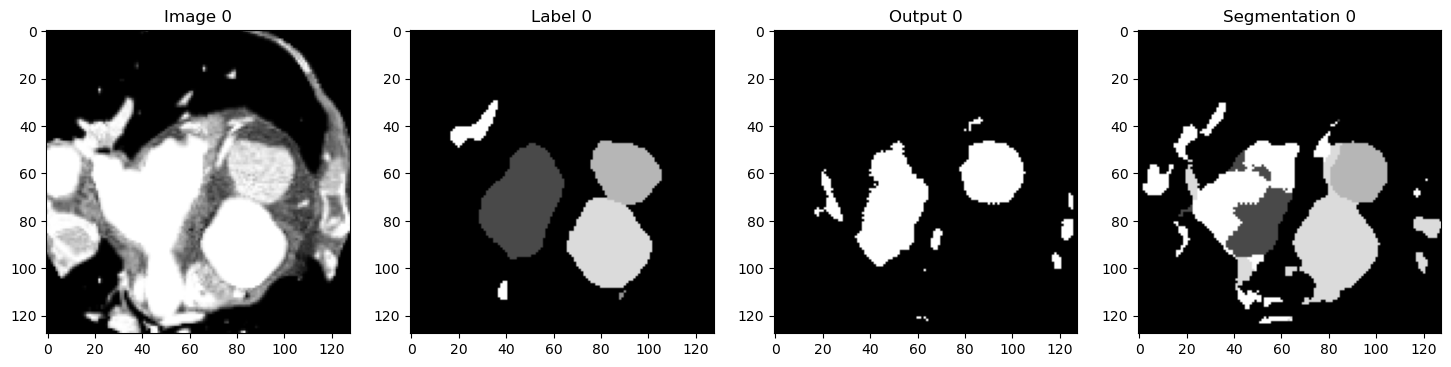

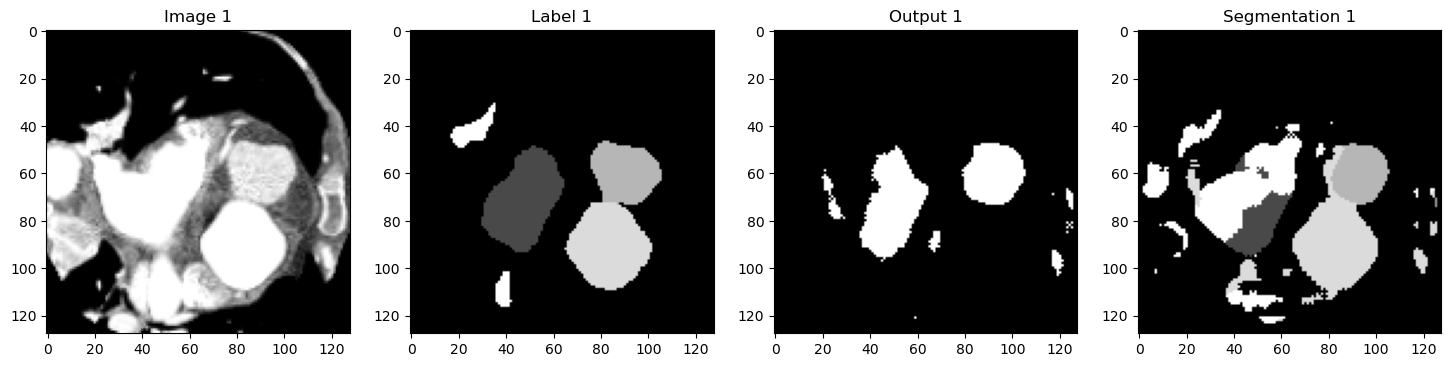

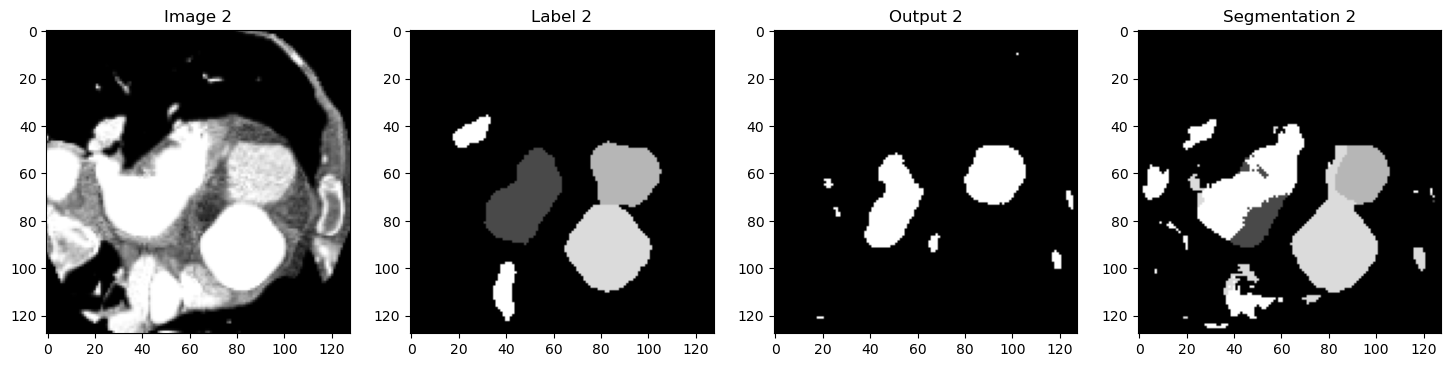

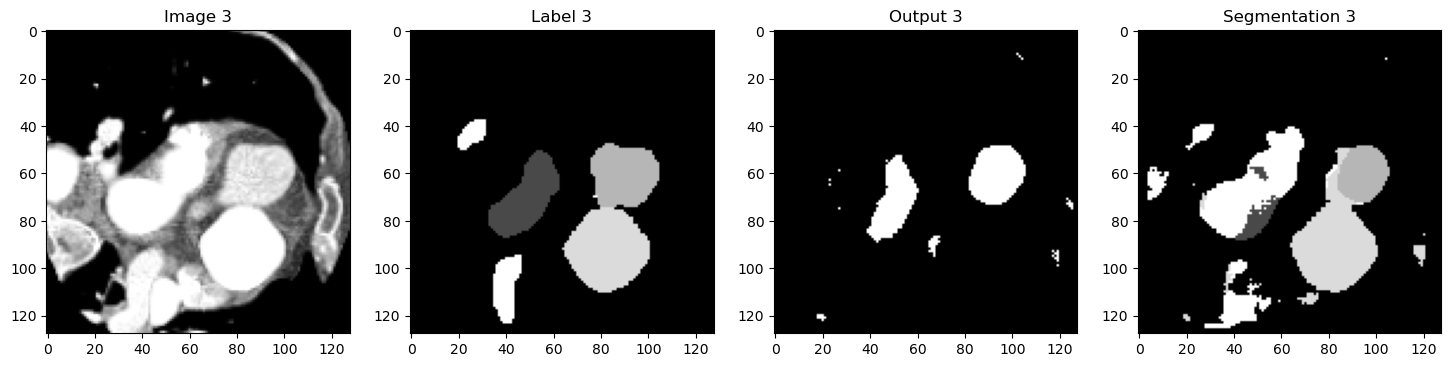

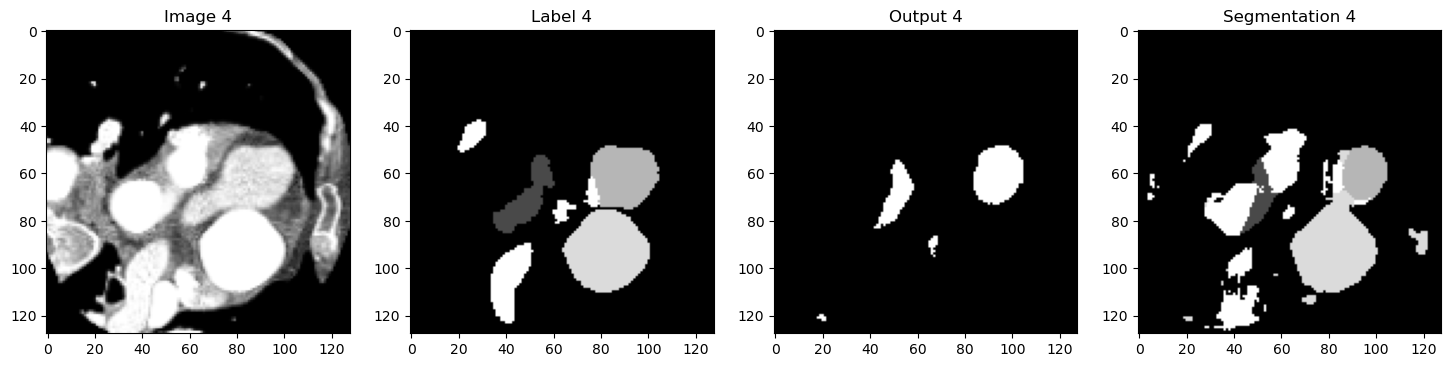

In [22]:
test_outputs = sigmoid_activation(test_outputs)
test_outputs = 1 - test_outputs
test_outputs = test_outputs > 0.53 #Make the Values binary, i think not effective for our cause

z=50
for i in range(5):
        plt.figure('check', (18, 6))
        plt.subplot(1, 4, 1)
        plt.title(f'Image {i}')
        plt.imshow(test_patient['vol'][0, 0, :, :, i+z], cmap = 'gray')
        plt.subplot(1, 4, 2)
        plt.title(f'Label {i}')
        plt.imshow(test_patient['seg'][0, 0, :, :, i+z], cmap ='gray')
        plt.subplot(1, 4, 3)
        plt.title(f'Output {i}')
        plt.imshow(test_outputs.detach().cpu()[0, 0, :, :, i + z], cmap = 'gray')
        
        plt.subplot(1, 4, 4)
        plt.title(f'Segmentation {i}')
        plt.imshow(prediction.detach().cpu()[0,0, :, :, i + z], cmap = 'gray')
        plt.show()
        

In [12]:
utils.save_nifti(prediction = prediction,
                 out_dir = Path.cwd().parent)

[INFO] Saving Nifti file to j:\Meine Ablage\@ Adrian\__heartsegmentation


In [32]:
nifti_prediction = prediction.squeeze()
print(nifti_prediction.shape)
nib.save(nib.Nifti1Image(prediction.squeeze().cpu().numpy().astype(float), affine = None), 'test.nii.gz')

torch.Size([128, 128, 64])


In [31]:
target_size = (512, 512, 363)



# Interpolation durchführen
resized_prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(0).type(torch.float),  # Batch- und Kanal-Dimension hinzufügen
    size=target_size,
    mode='trilinear',  # Dreidimensionale Interpolation
    align_corners=False
)

# Die zusätzlichen Dimensionen wieder entfernen
resized_prediction = resized_prediction.squeeze(0).squeeze(0)

# Überprüfen der Größe
print(resized_prediction.shape)
nib.save(nib.Nifti1Image(resized_prediction.cpu().numpy().astype(float), affine = None), 'test2.nii.gz')

torch.Size([512, 512, 363])


In [27]:
prediction.shape

torch.Size([1, 128, 128, 64])